## Worgroup 6

- Andrea Ulloa
- Ángela Coapaza
- Ana Angulo

## CAUSAL FOREST

We have to replicate the results found in the paper of Athey and Wager (2018). For this code we follow this \href{repo}{} to help us for the work.

And then we describe in detail the results we found in the next sections of the code:

1. How the tree was built?
2. Estimate ATE
3. Run best linear predictor analysis
4. Look at school-wise heterogeneity
5. Analysis ignoring clusters. How do the results change?
6. Analysis without fitting the propensity score
7. The code plot six plots in the Make some plots section, so explain what you find there.
8. Visualize school-level covariates by treatment heterogeneity
9. CATE by school

In [1]:
# Notes:
# - The paper refers to an argument called `samples.per.cluster`. This option was removed in grf version 1.0
# and is now by default (`equalize.cluster.weights = FALSE`) internally set to the size of the largest cluster,
# which means that large schools recieve larger weight than small schools. To be closer to the original behavior,
# this script has been updated by setting `equalize.cluster.weights` to TRUE, which means each school receives
# equal weight in ATE estimation.
#
# For more details on clustering in grf, see the algorithm reference at:
# https://grf-labs.github.io/grf/REFERENCE.html#cluster-robust-estimation


In [2]:
set.seed(1)
rm(list = ls())

In [3]:
install.packages("grf")
install.packages("Hmisc")

library(grf)
if(packageVersion("grf") < '0.10.2') {
  warning("This script requires grf 0.10.2 or higher")
}
library(sandwich)
library(lmtest)
library(Hmisc)
library(ggplot2)


Installing package into 'C:/Users/ANA/Documents/R/win-library/4.1'
(as 'lib' is unspecified)



package 'grf' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ANA\AppData\Local\Temp\RtmpqYUAx2\downloaded_packages


Installing package into 'C:/Users/ANA/Documents/R/win-library/4.1'
(as 'lib' is unspecified)



package 'Hmisc' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ANA\AppData\Local\Temp\RtmpqYUAx2\downloaded_packages


Warning message:
"package 'grf' was built under R version 4.1.3"
Warning message:
"package 'sandwich' was built under R version 4.1.3"
Warning message:
"package 'lmtest' was built under R version 4.1.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.1.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'Hmisc' was built under R version 4.1.3"
Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2

Warning message:
"replacing previous import 'lifecycle::last_warnings' by 'rlang::last_warnings' when loading 'tibble'"

Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units




In [4]:
data.all = read.csv("../../../../data_lab/synthetic_data.csv")
head(data.all)

,schoolid,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,76,1,0.08160167,6,4,2,1,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
2,76,1,-0.38586896,4,12,2,1,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
3,76,1,0.39818373,6,4,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
4,76,1,-0.17503685,6,4,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
5,76,1,0.88458337,6,4,1,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
6,76,1,-0.09056477,6,4,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567


In [5]:
# Changing the variable type of schoolid, from int to factor
data.all$schoolid = factor(data.all$schoolid)

In [6]:
DF = data.all[,-1] # Without schoolid
school.id = as.numeric(data.all$schoolid) # we get the numbers from the schoolid column

# We get a matrix with only the variable schoolid, without intercept
school.mat = model.matrix(~ schoolid + 0, data = data.all)
head(school.mat)

# sum the schoolid column of the array school.mat
school.size = colSums(school.mat)


,schoolid1,schoolid2,schoolid3,schoolid4,schoolid5,schoolid6,schoolid7,schoolid8,schoolid9,schoolid10,...,schoolid67,schoolid68,schoolid69,schoolid70,schoolid71,schoolid72,schoolid73,schoolid74,schoolid75,schoolid76
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# It appears that school ID does not affect pscore. So ignore it
# in modeling, and just treat it as source of per-cluster error.
w.lm = glm(Z ~ ., data = data.all[,-3], family = binomial)
summary(w.lm)


Call:
glm(formula = Z ~ ., family = binomial, data = data.all[, -3])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2079  -0.9088  -0.8297   1.4176   1.9556  

Coefficients: (6 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.9524636  0.2845173  -3.348 0.000815 ***
schoolid2    0.0697302  0.2766287   0.252 0.800986    
schoolid3    0.0382080  0.2911323   0.131 0.895586    
schoolid4    0.1761334  0.2784711   0.633 0.527059    
schoolid5   -0.0033389  0.2950180  -0.011 0.990970    
schoolid6    0.0583548  0.3067481   0.190 0.849124    
schoolid7   -0.1313759  0.3188190  -0.412 0.680288    
schoolid8    0.1233661  0.3023736   0.408 0.683279    
schoolid9   -0.1955428  0.3073344  -0.636 0.524611    
schoolid10  -0.1892794  0.2968750  -0.638 0.523752    
schoolid11  -0.2224060  0.5461005  -0.407 0.683816    
schoolid12  -0.3312420  0.5414374  -0.612 0.540682    
schoolid13  -0.0408540  0.3989507  -0.102 0.9

In [8]:
W = DF$Z
Y = DF$Y
X.raw = DF[,-(1:2)]

# There are 4 categories of the variable C1 (1 to 15) and 5 categories of the variable XC (0 to 4).
# We are creating two arrays, one for the variable C1 that creates dummy variables for each category, 
# and another one for the variable XC that creates dummy variables for each category. 
# Mark 1 if the observation was classified in that category.

C1.exp = model.matrix(~ factor(X.raw$C1) + 0)
XC.exp = model.matrix(~ factor(X.raw$XC) + 0)

head(XC.exp) # 15 columnas 
head(C1.exp) # 5 columnas


,factor(X.raw$XC)0,factor(X.raw$XC)1,factor(X.raw$XC)2,factor(X.raw$XC)3,factor(X.raw$XC)4
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
6,0,0,0,0,1


,factor(X.raw$C1)1,factor(X.raw$C1)2,factor(X.raw$C1)3,factor(X.raw$C1)4,factor(X.raw$C1)5,factor(X.raw$C1)6,factor(X.raw$C1)7,factor(X.raw$C1)8,factor(X.raw$C1)9,factor(X.raw$C1)10,factor(X.raw$C1)11,factor(X.raw$C1)12,factor(X.raw$C1)13,factor(X.raw$C1)14,factor(X.raw$C1)15
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# Finally we finish constructing the matrix X with the control variables 
# and replacing instead of only one column for C1 and XC, several dummies according to each category
X = cbind(X.raw[,-which(names(X.raw) %in% c("C1", "XC"))], C1.exp, XC.exp)
head(X) 

,S3,C2,C3,X1,X2,X3,X4,X5,factor(X.raw$C1)1,factor(X.raw$C1)2,...,factor(X.raw$C1)11,factor(X.raw$C1)12,factor(X.raw$C1)13,factor(X.raw$C1)14,factor(X.raw$C1)15,factor(X.raw$XC)0,factor(X.raw$XC)1,factor(X.raw$XC)2,factor(X.raw$XC)3,factor(X.raw$XC)4
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,2,1,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4,2,1,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,1,0,0,0,0,0,0,0,1
3,6,2,0,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1
4,6,2,0,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1
5,6,1,0,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1
6,6,2,0,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1


Grow a forest. Add extra trees for the causal forest.
### 1. How the tree was built?

In [10]:
# First, we do two regression forest: Y.forest and W. forest, knowing that there are school clauster
# Then, we calculate  the predicted values of the two variables (Y.hat and W.hat)

Y.forest = regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
W.hat = predict(W.forest)$predictions



In [11]:
# Second, we use the predictions obtained before for the causal forest

cf.raw = causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)

#we obtain the degree of importance of each control variable
varimp = variable_importance(cf.raw)

#We chose the most important variables because they are the ones with a degree 
#of importance greater than the average.
selected.idx = which(varimp > mean(varimp))

We run a second causal forest again but only with the most important explanatory (or control) variables for the model.

In [12]:
cf = causal_forest(X[,selected.idx], Y, W,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id,
                   equalize.cluster.weights = TRUE,
                   tune.parameters = "all")
tau.hat = predict(cf)$predictions # we get the estimated coefficients


### 2. Estimate ATE

In [13]:
# The package grf has a built-in function for average treatment effect estimation, based on a variant
# of augmented inverse propensity weighting.

ATE = average_treatment_effect(cf)

# Print results
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))

[1] "95% CI for the ATE: 0.248 +/- 0.039"

The average treatment effect is 0.248. So, the result suggests that the treatment was significantly positive on average.

null device 
          1

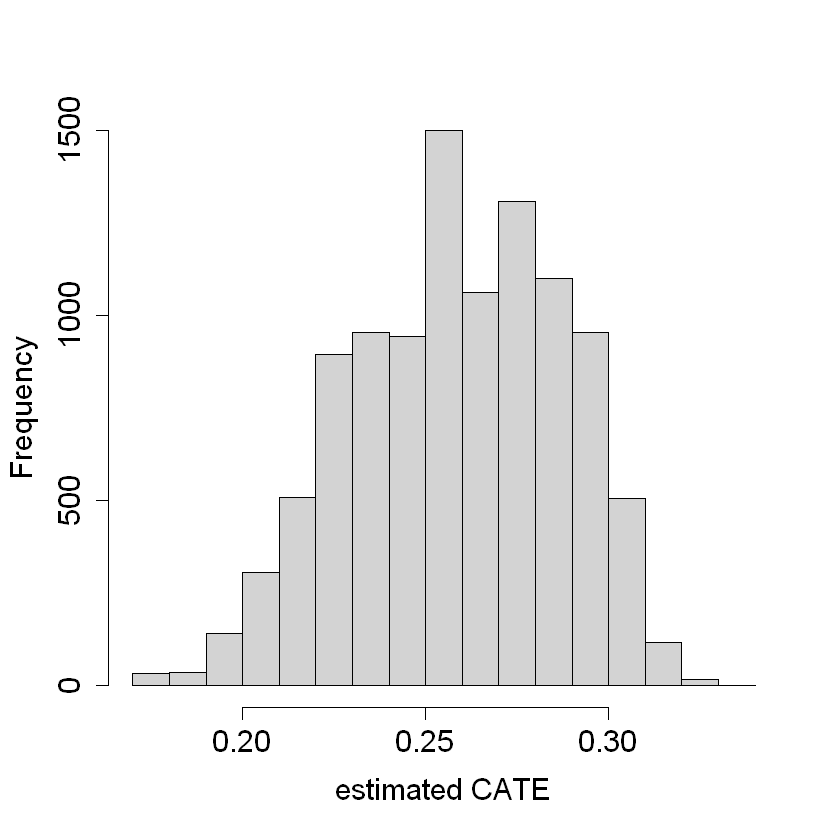

In [14]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat, xlab = "estimated CATE", main = "")
dev.off()

As we can see in the figure before, the causal forest CATE estimates obviously exhibit variation

### 3. Omnibus tests for heterogeneity - Run best linear predictor analysis

In [15]:
test_calibration(cf)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.996727   0.082132  12.136 <2e-16 ***
differential.forest.prediction 0.200832   0.616050   0.326 0.3722    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


A first, simple approach to testing for heterogeneity involves grouping observations according to whether their out-of-bag CATE estimates are above or below the median CATE estimate, and then estimating average treatment effects in these two subgroups separately using the doubly robust approach.

In [16]:
# This is another approach to test heterogeneity. Compare regions with high and low estimated CATEs
high_effect = tau.hat > median(tau.hat)
ate.high = average_treatment_effect(cf, subset = high_effect)
ate.low = average_treatment_effect(cf, subset = !high_effect)
paste("95% CI for difference in ATE:",
      round(ate.high[1] - ate.low[1], 3), "+/-",
      round(qnorm(0.975) * sqrt(ate.high[2]^2 + ate.low[2]^2), 3))


[1] "95% CI for difference in ATE: 0.058 +/- 0.07"

The results of both the analysis of the best linear predictor and the comparison of regions with low and high estimated CATE show the presence of heterogeneity. However, they are not significant, because the confidence interval is observed to contain zero. Therefore, it appears that causal forests do not identify subgroups with heterogeneous effects that are clearly detectable.

### 4. Look at school-wise heterogeneity

Although our omnibus tests did not found strong evidence of treatment heterogeneity, this does not mean there is no heterogeneity present. Researchers had pre-specified interest in heterogeneity along two specific variables, namely pre-existing mindset (X1) and school-level achievement (X2), and it is
plausible that a test for heterogeneity that focuses on these two variables may have more power than the agnostic tests explored above.

#### Formal test for X1 and X2

In [17]:
dr.score = tau.hat + W / cf$W.hat *
  (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

In [18]:
school.X1 = t(school.mat) %*% X$X1 / school.size
high.X1 = school.X1 > median(school.X1)
t.test(school.score[high.X1], school.score[!high.X1])


	Welch Two Sample t-test

data:  school.score[high.X1] and school.score[!high.X1]
t = -3.0365, df = 71.412, p-value = 0.00334
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.19234741 -0.03987287
sample estimates:
mean of x mean of y 
0.1903880 0.3064981 


In [19]:
school.X2 = (t(school.mat) %*% X$X2) / school.size
high.X2 = school.X2 > median(school.X2)
t.test(school.score[high.X2], school.score[!high.X2])


	Welch Two Sample t-test

data:  school.score[high.X2] and school.score[!high.X2]
t = 0.96525, df = 72.286, p-value = 0.3376
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0414292  0.1192237
sample estimates:
mean of x mean of y 
0.2678917 0.2289944 


In [20]:
school.X2.levels = cut(school.X2,
  breaks = c(-Inf, quantile(school.X2, c(1/3, 2/3)), Inf))
summary(aov(school.score ~ school.X2.levels))

                 Df Sum Sq Mean Sq F value Pr(>F)
school.X2.levels  2 0.0807 0.04034    1.32  0.273
Residuals        73 2.2313 0.03057               

Analysis uncovers notable heterogeneity along X1: schools with larger values of X1 appear to experience larger effects than schools with smaller values of X1. Conversely, we do not see much heterogeneity along X2 because the confidence interval contains zero.

### Formal test for S3


	One Sample t-test

data:  school.score.XS3.high - school.score.XS3.low
t = 2.244, df = 75, p-value = 0.02778
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.009554619 0.160661883
sample estimates:
 mean of x 
0.08510825 


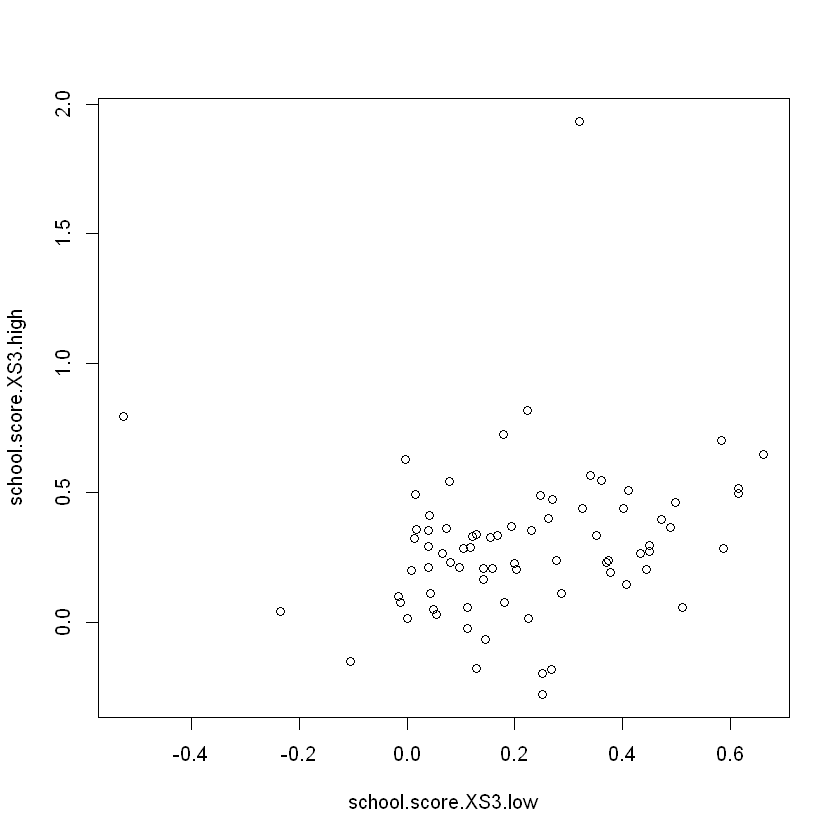

In [21]:
school.score.XS3.high = t(school.mat) %*% (dr.score * (X$S3 >= 6)) /
  t(school.mat) %*% (X$S3 >= 6)
school.score.XS3.low = t(school.mat) %*% (dr.score * (X$S3 < 6)) /
  t(school.mat) %*% (X$S3 < 6)

plot(school.score.XS3.low, school.score.XS3.high)
t.test(school.score.XS3.high - school.score.XS3.low)



In [22]:
### Look at school-wise heterogeneity

null device 
          1

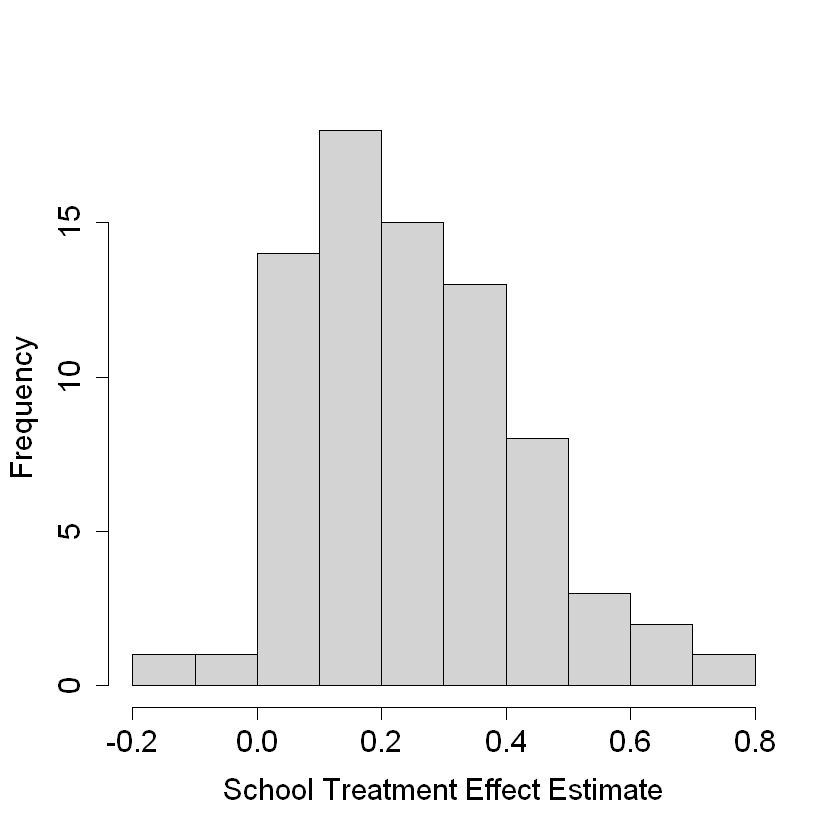

In [23]:
#pdf("school_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(school.score, xlab = "School Treatment Effect Estimate", main = "")
dev.off()



In the graph above, we can notice that the estimate of the treatment effect in schools is scattered. This leads to the assumption that there are heterogeneous effects by school.

### Re-check ATE

In [24]:
ate.hat = mean(school.score)
se.hat = sqrt(var(school.score) / length(school.score - 1))
print(paste(round(ate.hat, 3), "+/-", round(1.96 * se.hat, 3)))


[1] "0.248 +/- 0.039"


In [25]:
### Look at variation in propensity scores

null device 
          1

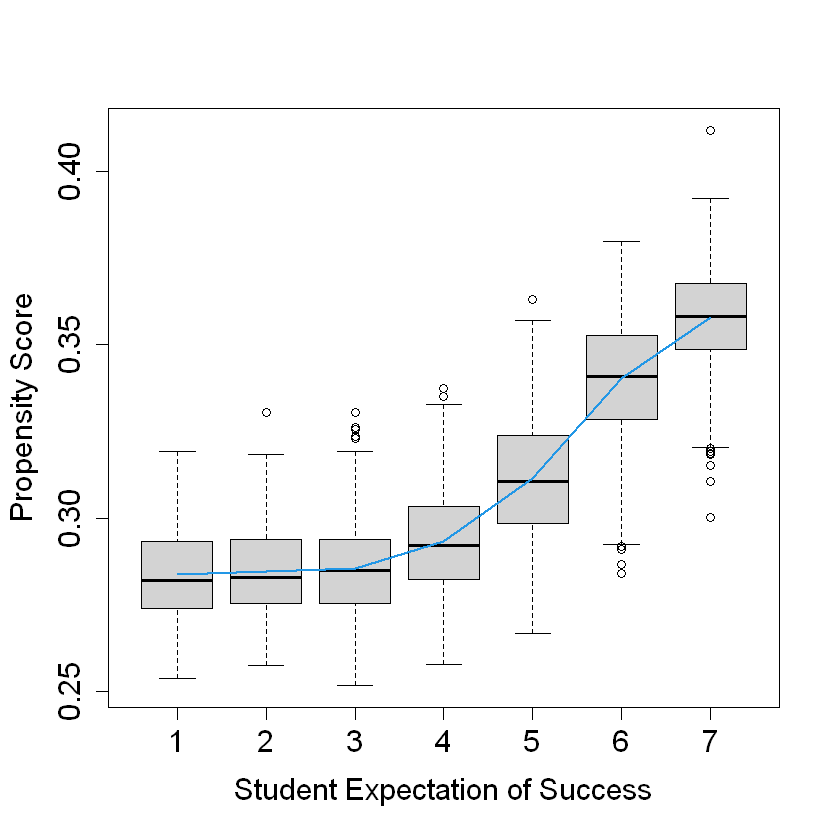

In [26]:
DF = X
DF$W.hat = cf$W.hat

#pdf("pscore.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(W.hat ~ S3, data = DF, ylab = "Propensity Score", xlab = "Student Expectation of Success")
lines(smooth.spline(X$S3, cf$W.hat), lwd = 2, col = 4)
dev.off()



The box plot above shows that students with higher expectations of success (S3) are more likely to receive the treatment.

### 5.	Analysis ignoring clusters. How do the results change?

In [27]:
# We do not specify whether there are clusters
cf.noclust = causal_forest(X[,selected.idx], Y, W,
                           Y.hat = Y.hat, W.hat = W.hat,
                           tune.parameters = "all")

#Estimate ATE
ATE.noclust = average_treatment_effect(cf.noclust)
paste("95% CI for the ATE:", round(ATE.noclust[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noclust[2], 3))


[1] "95% CI for the ATE: 0.254 +/- 0.022"

In [28]:
# We test for heterogeneity
test_calibration(cf.noclust)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value    Pr(>t)    
mean.forest.prediction         1.014372   0.045172  22.456 < 2.2e-16 ***
differential.forest.prediction 0.534271   0.132375   4.036 2.738e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


The previous test shows that there is heterogeneity, since both the mean of the forest predictions and the differential of the forest predictions are significant at 1%.

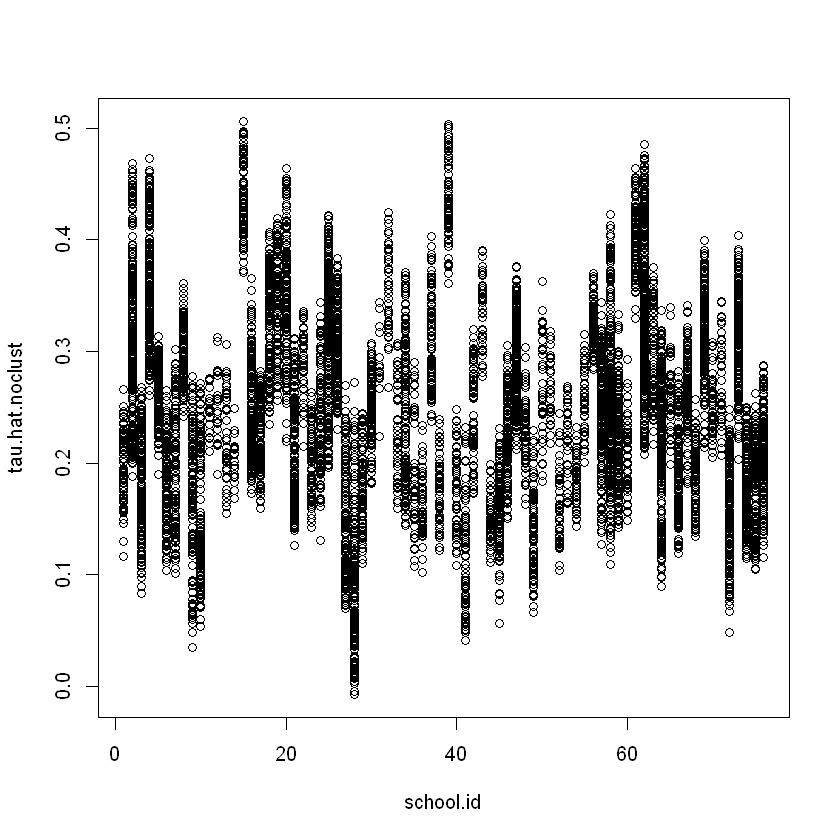

In [29]:
# Ploting predictions of the causal forest without clustering
tau.hat.noclust = predict(cf.noclust)$predict
plot(school.id, tau.hat.noclust)

In [30]:
nfold = 5
school.levels = unique(school.id)
cluster.folds = sample.int(nfold, length(school.levels), replace = TRUE)

tau.hat.crossfold = rep(NA, length(Y))
for (foldid in 1:nfold) {
  print(foldid)
  infold = school.id %in% school.levels[cluster.folds == foldid]
  cf.fold = causal_forest(X[!infold, selected.idx], Y[!infold], W[!infold],
                          Y.hat = Y.hat[!infold], W.hat = W.hat[!infold],
                          tune.parameters = "all")
  pred.fold = predict(cf.fold, X[infold, selected.idx])$predictions
  tau.hat.crossfold[infold] = pred.fold
}

cf.noclust.cpy = cf.noclust
cf.noclust.cpy$predictions = tau.hat.crossfold
cf.noclust.cpy$clusters = school.id
test_calibration(cf.noclust.cpy)

Rloss = mean(((Y - Y.hat) - tau.hat * (W - W.hat))^2)
Rloss.noclust = mean(((Y - Y.hat) - tau.hat.noclust * (W - W.hat))^2)
Rloss.crossfold = mean(((Y - Y.hat) - tau.hat.crossfold * (W - W.hat))^2)

c(Rloss.noclust - Rloss, Rloss.crossfold - Rloss)

summary(aov(dr.score ~ factor(school.id)))


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value  Pr(>t)    
mean.forest.prediction         1.009952   0.065094 15.5153 < 2e-16 ***
differential.forest.prediction 0.458118   0.245527  1.8659 0.03105 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] -0.0000220815  0.0001425884

                     Df Sum Sq Mean Sq F value   Pr(>F)    
factor(school.id)    75    201   2.678   1.982 1.02e-06 ***
Residuals         10315  13935   1.351                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

### 6. Analaysis without fitting the propensity score

[1] "95% CI for the ATE: 0.254 +/- 0.039"

null device 
          1

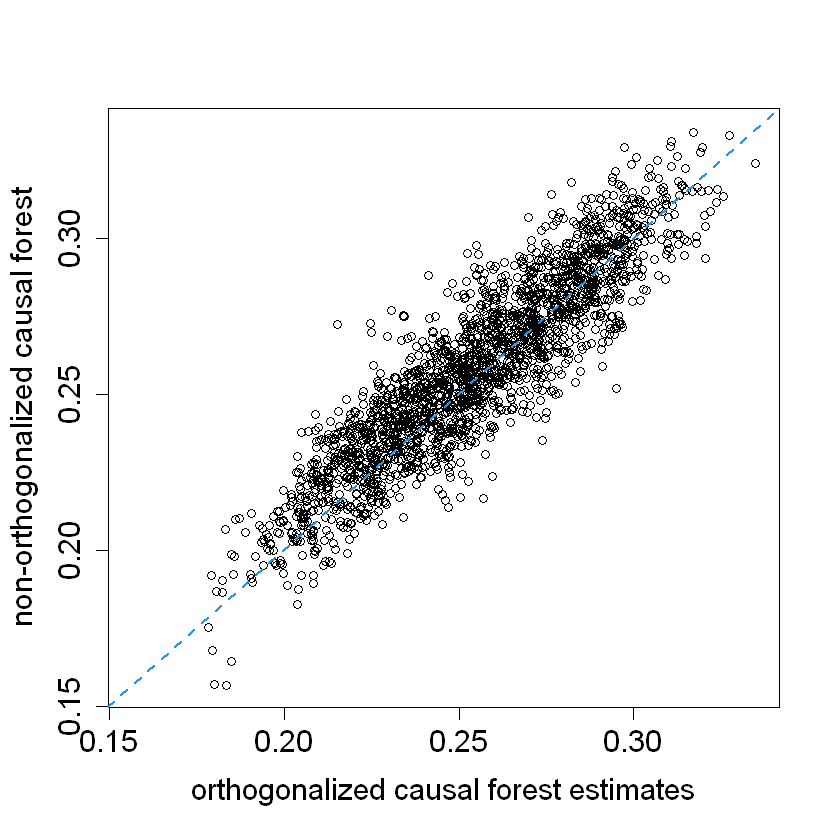

In [31]:

cf.noprop = causal_forest(X[,selected.idx], Y, W,
                          Y.hat = Y.hat, W.hat = mean(W),
                          tune.parameters = "all",
                          equalize.cluster.weights = TRUE,
                          clusters = school.id)
tau.hat.noprop = predict(cf.noprop)$predictions

ATE.noprop = average_treatment_effect(cf.noprop)
paste("95% CI for the ATE:", round(ATE.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noprop[2], 3))

#pdf("tauhat_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(tau.hat, tau.hat.noprop,
     xlim = range(tau.hat, tau.hat.noprop),
     ylim = range(tau.hat, tau.hat.noprop),
     xlab = "orthogonalized causal forest estimates",
     ylab = "non-orthogonalized causal forest")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
dev.off()




It is observed that forests trained with or without orthogonalization result in the same CATE estimates. So orthogonalization seems to be less important than clustering. This may be because for both W and Y forest , the variable of students' expectations of success(S3) is the most important predictor.

### Train forest on school-wise DR scores

In [32]:
school.X = (t(school.mat) %*% as.matrix(X[,c(4:8, 25:28)])) / school.size
school.X = data.frame(school.X)
colnames(school.X) = c("X1", "X2", "X3", "X4", "X5",
                    "XC.1", "XC.2", "XC.3", "XC.4")

dr.score = tau.hat + W / cf$W.hat * (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.forest = regression_forest(school.X, school.score)
school.pred = predict(school.forest)$predictions
test_calibration(school.forest)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.999512   0.081949  12.197 <2e-16 ***
differential.forest.prediction 0.680739   0.655182   1.039 0.1511    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Although the p-value for heterogeneity along X1 is not small enough to withstand a Bonferroni test, it seems reasonable to take the detection along X1 seriously because heterogeneity along X1 was one of two prespecified hypotheses. Also, it's interesting that X1 was the most important variable in the causal forest.

In [33]:
# Alternative OLS analysis
school.DF = data.frame(school.X, school.score=school.score)
coeftest(lm(school.score ~ ., data = school.DF), vcov = vcovHC)


t test of coefficients:

              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.2412696  0.0771218  3.1284 0.002616 **
X1          -0.0504144  0.0291605 -1.7289 0.088509 . 
X2           0.0127667  0.0336429  0.3795 0.705552   
X3           0.0104740  0.0266411  0.3932 0.695474   
X4           0.0235292  0.0255123  0.9223 0.359748   
X5          -0.0357527  0.0269103 -1.3286 0.188559   
XC.1         0.0013382  0.0937302  0.0143 0.988652   
XC.2         0.0884114  0.1049088  0.8427 0.402415   
XC.3        -0.1346624  0.0876731 -1.5360 0.129329   
XC.4         0.0424256  0.0816214  0.5198 0.604952   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


### 7. Describing 6 plots of the paper

null device 
          1

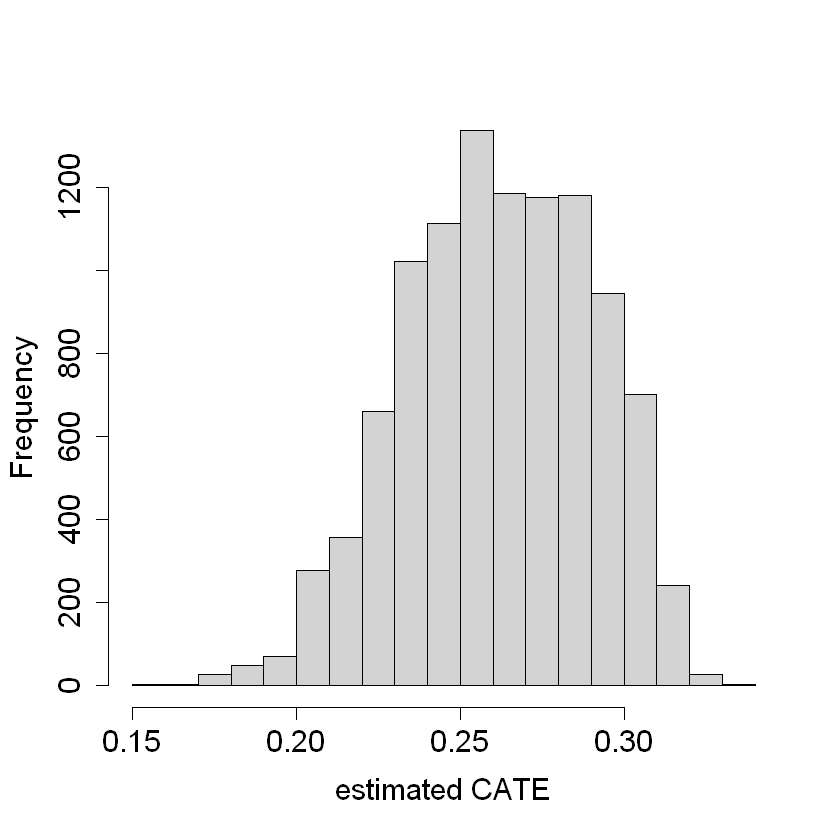

In [34]:
#pdf("tauhat_hist_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noprop, xlab = "estimated CATE", main = "")
dev.off()



null device 
          1

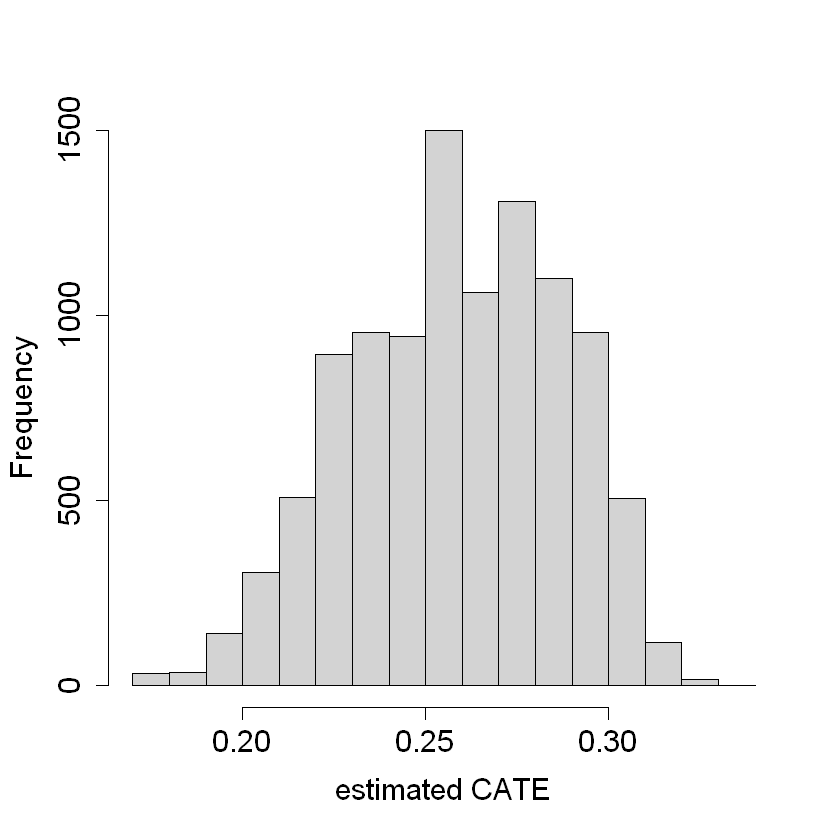

In [35]:
#pdf("tauhat_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat, xlab = "estimated CATE", main = "")
dev.off()

It is noted that the distribution has a mean around approximately 0.25 to 0.30, and is spread out around this. The fact that the distribution is scattered is not necessarily a sign of heterogeneity, but the initial tests of the work were carried out for this.

null device 
          1

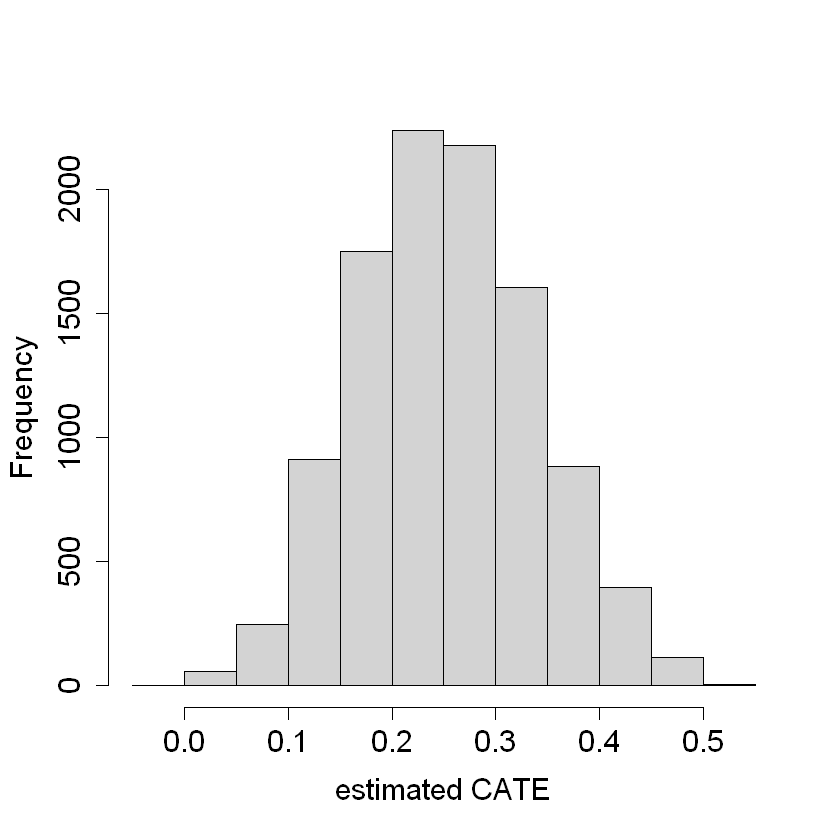

In [36]:
#pdf("tauhat_hist_noclust.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noclust, xlab = "estimated CATE", main = "")
dev.off()

Is a histogram of CATE estimates trained using a causal forest that Does not account for school-level clustering

null device 
          1

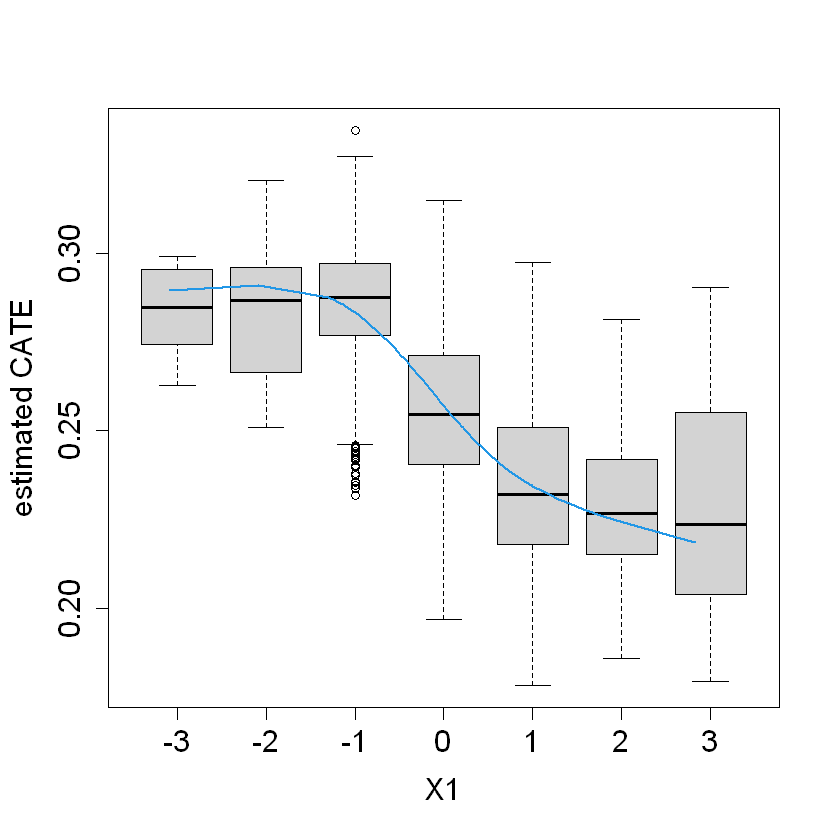

In [37]:
#pdf("tauhat_vs_X1.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X1), xlab = "X1", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X1"], tau.hat, df = 4), lwd = 2, col = 4)
dev.off()




In this graph we observe that, as we had found before, the heterogeneity of X1 by school was significant. In other words, there is a different mean value for a different level of mentality per school.

null device 
          1

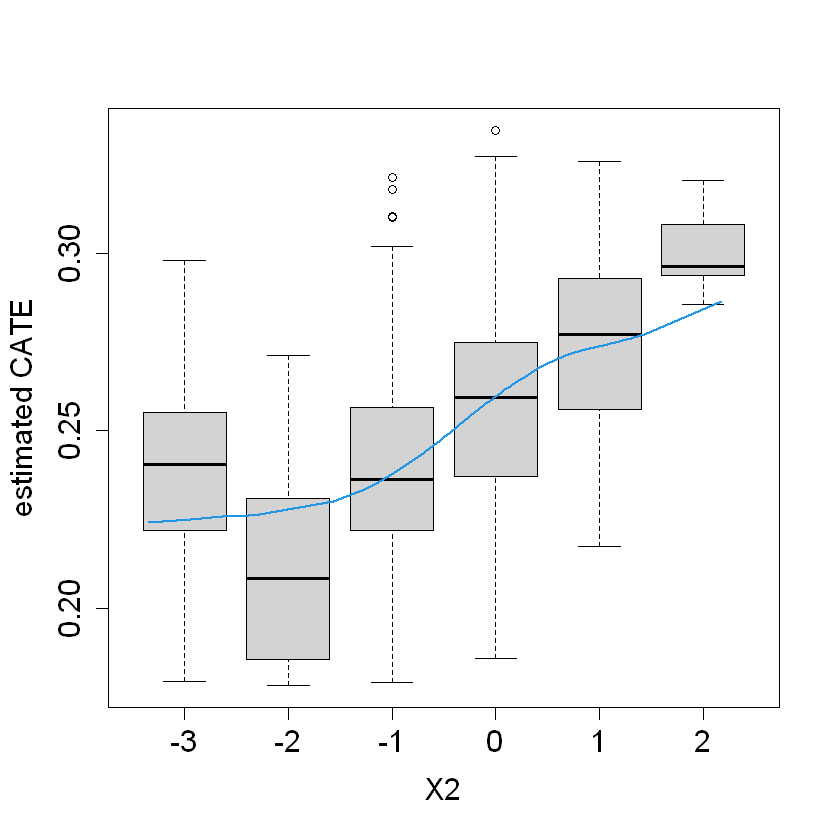

In [38]:
#pdf("tauhat_vs_X2.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X2), xlab = "X2", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X2"], tau.hat, df = 4), lwd = 2, col = 4)
dev.off()

school.avg.tauhat = t(school.mat) %*% tau.hat / school.size



Also, in this graph we see that the mean value of the CATE varies according to the values of the level of school achievement (X2). However, we had previously found that there was no significant heterogeneity.

null device 
          1

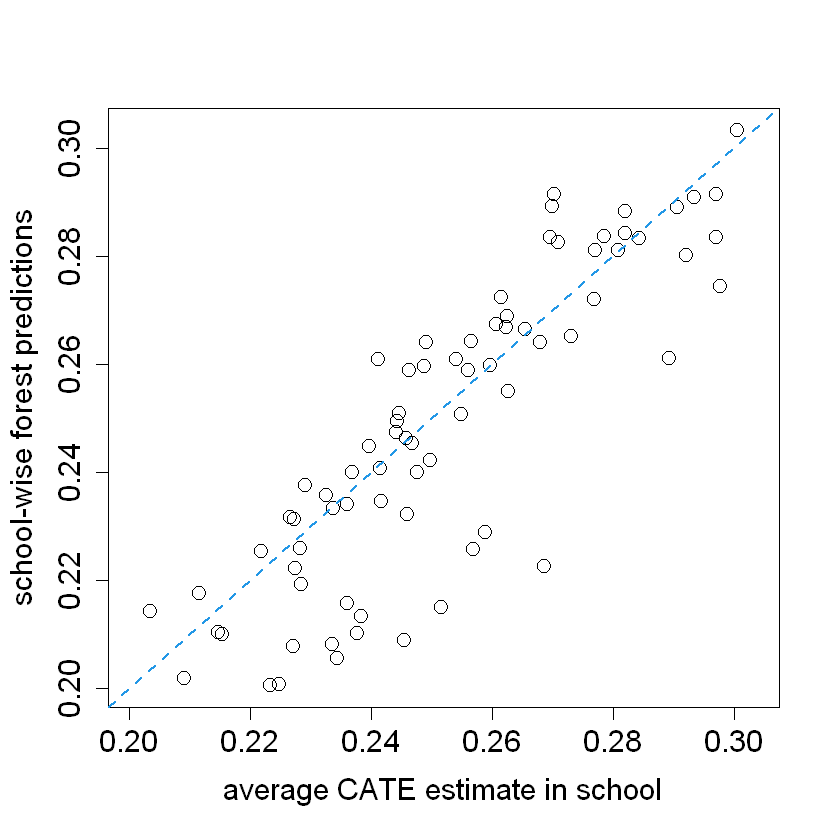

In [39]:
#pdf("school_avg.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(school.avg.tauhat, school.pred, cex = 1.5,
     xlim = range(school.avg.tauhat, school.pred),
     ylim = range(school.avg.tauhat, school.pred),
     xlab = "average CATE estimate in school",
     ylab = "school-wise forest predictions")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
dev.off()

This plot compares estimates from a regression forest trained to predict a doubly robust treatment using estimates of the school effect using school-level covariates, with estimates of school means from causal forests.

In [40]:
### Experiment with no orthogonalization

In [41]:
n.synth = 1000
p.synth = 10
X.synth = matrix(rnorm(n.synth * p.synth), n.synth, p.synth)
W.synth = rbinom(n.synth, 1, 1 / (1 + exp(-X.synth[,1])))
Y.synth = 2 * rowMeans(X.synth[,1:6]) + rnorm(n.synth)

Y.forest.synth = regression_forest(X.synth, Y.synth)
Y.hat.synth = predict(Y.forest.synth)$predictions
W.forest.synth = regression_forest(X.synth, W.synth)
W.hat.synth = predict(W.forest.synth)$predictions

cf.synth = causal_forest(X.synth, Y.synth, W.synth,
                         Y.hat = Y.hat.synth, W.hat = W.hat.synth)
ATE.synth = average_treatment_effect(cf.synth)
paste("95% CI for the ATE:", round(ATE.synth[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth[2], 3))

cf.synth.noprop = causal_forest(X.synth, Y.synth, W.synth,
                                Y.hat = Y.hat.synth, W.hat = mean(W.synth))
ATE.synth.noprop = average_treatment_effect(cf.synth.noprop)
paste("95% CI for the ATE:", round(ATE.synth.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth.noprop[2], 3))



[1] "95% CI for the ATE: -0.055 +/- 0.144"

[1] "95% CI for the ATE: 0.055 +/- 0.143"

In [42]:
### Visualize school-level covariates by treatment heterogeneity

[1] 0.2105263

[1] 0.5384615

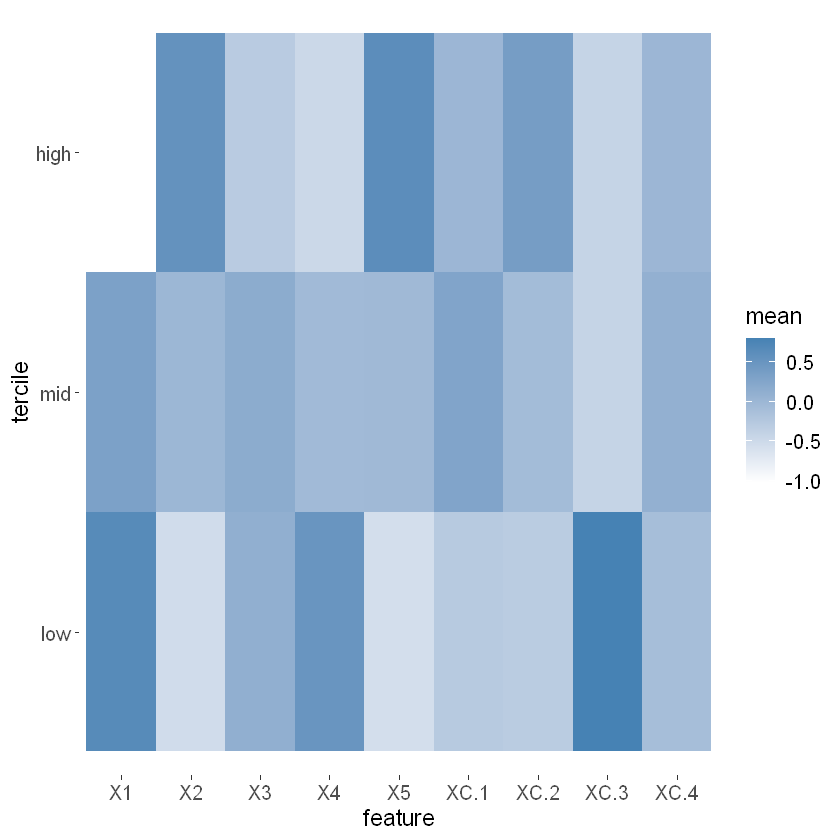

In [43]:
school.X.std = scale(school.X)
school.tercile = cut(school.pred,
                     breaks = c(-Inf, quantile(school.pred, c(1/3, 2/3)), Inf))
school.tercile.mat = model.matrix(~ school.tercile + 0)
school.means = diag(1 / colSums(school.tercile.mat)) %*% t(school.tercile.mat) %*% as.matrix(school.X.std)

MM = max(abs(school.means))
HC = heat.colors(21)
school.col = apply(school.means, 1:2, function(aa) HC[1 + round(20 * (0.5 + aa))])

DF.plot = data.frame(tercile=rep(factor(1:3, labels=c("low", "mid", "high")), 9), mean=as.numeric(school.means),
                     feature = factor(rbind(colnames(school.X), colnames(school.X), colnames(school.X))))

ggplot(data = DF.plot, aes(x = feature, y = tercile, fill = mean)) +
    geom_tile() + scale_fill_gradient(low = "white", high = "steelblue") +
    theme(axis.text = element_text(size=12), axis.title = element_text(size=14),
          legend.title = element_text(size=14), legend.text = element_text(size=12)) +
    theme(panel.background = element_blank())
#ggsave("tercile_plot.pdf", width = 8, height = 4.5, dpi = 120)

mean(school.X$XC.3)
mean(school.X$XC.3[as.numeric(school.tercile) == 1])



### CATE by school

null device 
          1

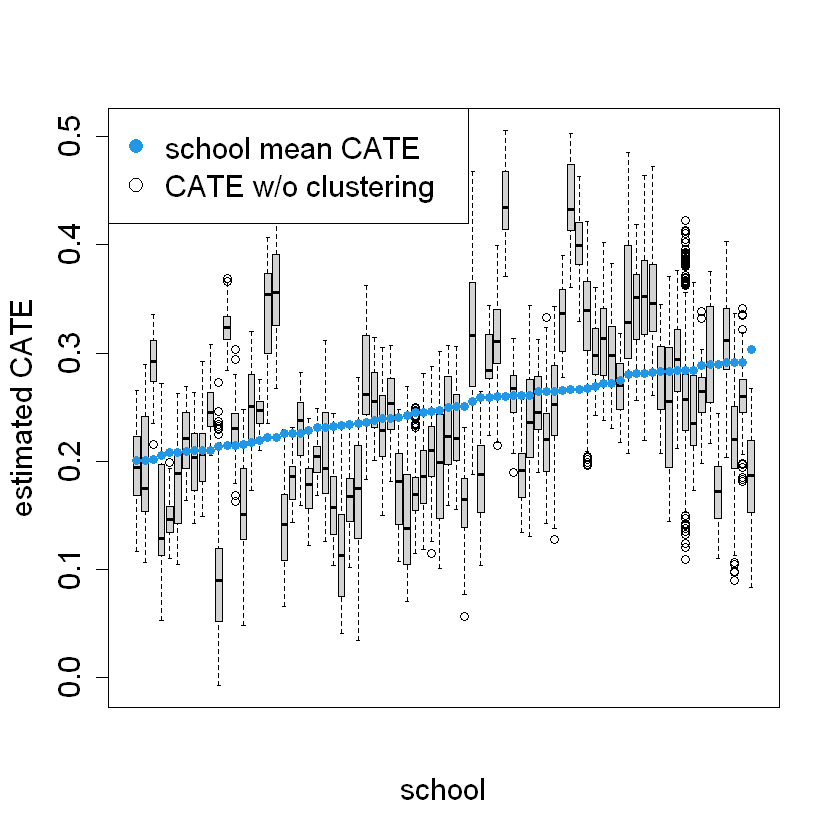

In [44]:
ord = order(order(school.pred))
school.sort = ord[school.id]

#pdf("school_boxplot.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat.noclust ~ school.sort, xaxt = "n",
        xlab = "school", ylab = "estimated CATE")
points(1:76, sort(school.pred), col = 4, pch = 16)
legend("topleft", c("school mean CATE", "CATE w/o clustering"), pch = c(16, 1), col = c(4, 1), cex = 1.5)
par = pardef
dev.off()